# Medical Appointment No-Shows

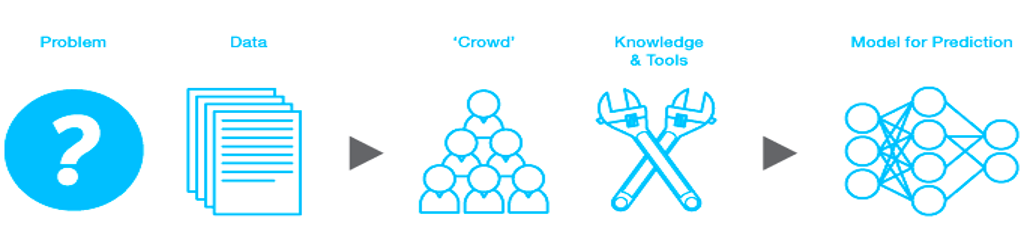
The goal for this project was to carry out the following steps: it was to first identify a problem. Next, obtain clean data. Then, explore the data and understand the variables, and finally utilize the knowledge and tools of mathematical modeling to ultimately create a model for predictive analytics.

I wanted to create a model that analyzed human behavior and also related to the field of public health & medicine, so I chose a dataset that could aid in answering the question, "Why do 30% of patients miss their scheduled appointments?"

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.interpolate import interp1d
from datetime import date
import calendar
import os

os.chdir('C:/Users/Sharon/Desktop/DataScience/Chapman Fall 2017/CS 520/Project/Data')

In [49]:
sb.set_style("whitegrid")

"""sns.set_style preset themes: darkgrid, whitegrid, 
dark, white, ticks
"""

aptdata = pd.read_csv('data.csv')
aptdata=aptdata.rename(columns = {'Neighbourhood':'Neighborhood','Hipertension':'Hypertension','Handcap':'Handicap'})

In [50]:
aptdata.info()
'No Null Values'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighborhood      110527 non-null object
Scholarship       110527 non-null int64
Hypertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handicap          110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


'No Null Values'

In [51]:
aptdata.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [52]:
aptdata['ScheduledDay']=pd.to_datetime(aptdata['ScheduledDay'])
aptdata['AppointmentDay']=pd.to_datetime(aptdata['AppointmentDay'])
aptdata['daystillapt']=(aptdata['AppointmentDay']-aptdata['ScheduledDay']).dt.days
aptdata.loc[aptdata['daystillapt']<0,'daystillapt']=0

In [53]:
aptdata['WeekdayNum']=aptdata['AppointmentDay'].dt.weekday

'''edit data so that numerical analysis can be done'''
aptdata.loc[aptdata['Age']<0,'Age']=0
aptdata.loc[aptdata['No-show']=='No','Show']=1
aptdata.loc[aptdata['No-show']=='Yes','Show']=0
aptdata.loc[aptdata['Gender']=='F','Sex']=1
aptdata.loc[aptdata['Gender']=='M','Sex']=0
aptdata['Neighborhood'] = aptdata.Neighborhood.astype('category')
aptdata['Neighborhood'] = aptdata['Neighborhood'].cat.codes

In [54]:
aptdata.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,daystillapt,WeekdayNum,Show,Sex
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,39,0,1,0,0,0,0,No,0,4,1.0,1.0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,39,0,0,0,0,0,0,No,0,4,1.0,0.0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,45,0,0,0,0,0,0,No,0,4,1.0,1.0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,54,0,0,0,0,0,0,No,0,4,1.0,1.0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,39,0,1,1,0,0,0,No,0,4,1.0,1.0


# The Data
The dataset that was pulled from kaggle contains over one hundred thousand medical appointments that were scheduled for 2016 in Vitoria, Espirito Santo, Brazil.  It contains over 15 variables such as gender, age, medical history, what day of the week the appointment was, and most importantly, if the patient showed up to the appointment or not.  Python was used for the analysis.  Some assumptions that were made were that all of the patients were visiting a primary care physican and not a specialist.

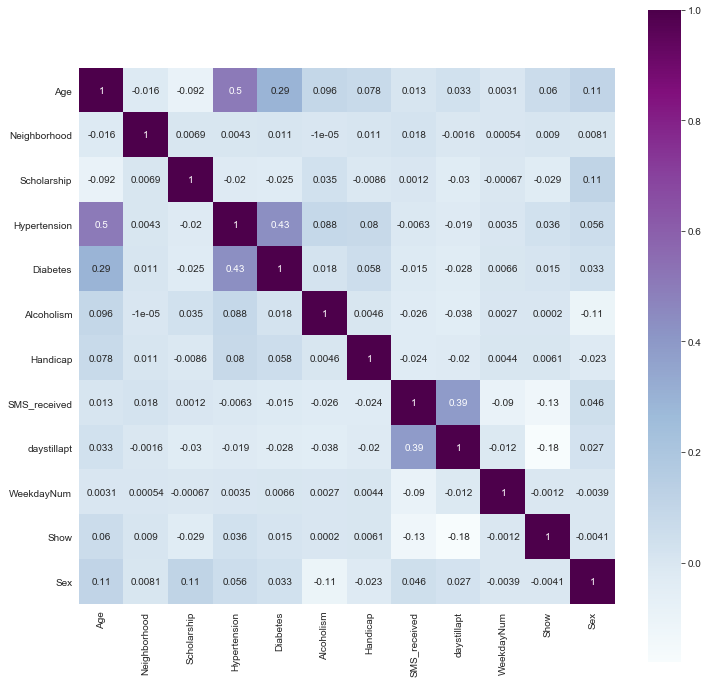

In [55]:
plt.figure(figsize=(12,12))
sb.heatmap(aptdata.iloc[:, 2:].corr(), annot=True, square=True, cmap='BuPu')
plt.show()

# Exploring Variables
I wanted to visually see how the data was correlated so I used a heat map to illustrate the correlation between each variable.  I wanted to observe the age, and pre-existing condition variables to see if there was a positive correlation between those variables and whether the patients came to their appointments. Although there was a positive correlation with these variables and whether the patients showed up to their appointments, the correlation coefficients were too close to zero to be statistically significant.

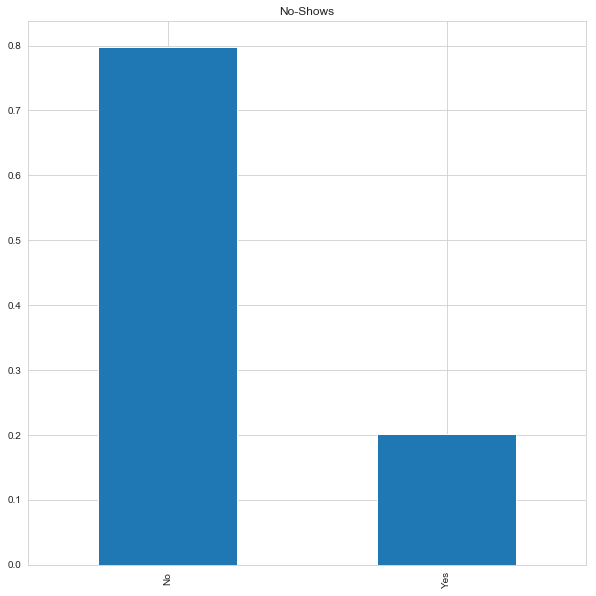

In [56]:
aptdata['No-show'].value_counts(normalize=True).plot.bar(figsize=(10,10), title= 'No-Shows')

### Exploring Variables cont.
About 80% of the participants showed up to their appointments and the other 20% of participants did not show up.

In [57]:
def probStatus(dataset,variable):
    df=pd.crosstab(index=dataset[variable],columns=dataset['No-show'])
    df['probShowUp']=df['No']/(df['Yes']+df['No'])
    df=df.reset_index()
    return df

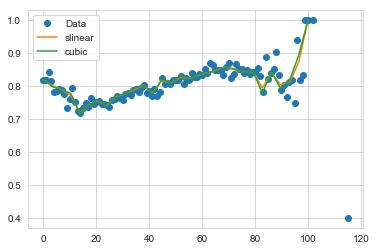

In [58]:
df=probStatus(aptdata,'Age')
x0=df['Age']
y0=df['probShowUp']
plt.plot(x0,y0,'o',label='Data')
x=np.linspace(0,100,30)
options = ('slinear','cubic')
for o in options:
    f=interp1d(x0,y0,kind=o)
    plt.plot(x,f(x),label=o)

plt.legend()
plt.show()

### Exploring Variables (Age)
Because mapping the correlation coefficients did not show us anything, I created a graph to show the probability of showing up with respect to age.  We can see that infants and elderly are more likely to show up to their appointments wheras adolescents to early adults are less likely to show up.

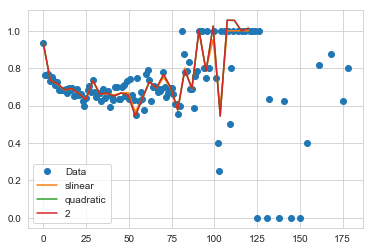

In [59]:
df=probStatus(aptdata,'daystillapt')
x0=df['daystillapt']
y0=df['probShowUp']
plt.plot(x0,y0,'o',label='Data')
x=np.linspace(0,120,30)
options = ('slinear','quadratic',2)
for o in options:
    f=interp1d(x0,y0,kind=o)
    plt.plot(x,f(x),label=o)

plt.legend()
plt.show()

### Exploring Variables (Days until appointment)
The graph below shows the probability of showing up with respect to days until appointment.  We can see that when appointments are scheduled sooner, patients are more likely to show up.  Especially when patients schedule appointments on the day of, they show up to their appointment.  This can also reflect walk in appointments as well, but information on this assumption for the data is limited.  After 50 days, the data becomes very sporadic.

In [60]:
def probStatusVariable(variable):
    rows=[]
    for item in variable:
        for level in aptdata[item].unique():
            row = {'Condition': item}
            total = len(aptdata[aptdata[item] == level])
            n = len(aptdata[(aptdata[item] == level) & (aptdata.Show == 1)])
            row.update({'Level': level, 'Probability': n/total})
            rows.append(row)
    return pd.DataFrame(rows)

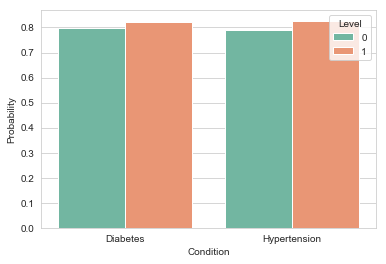

In [61]:
sb.barplot(data = probStatusVariable(['Diabetes', 'Hypertension']),
            x = 'Condition', y = 'Probability', hue = 'Level', palette = 'Set2')
plt.ylabel('Probability')
plt.show()

### Exploring Variables (Diabetes & Hypertension)
This bar graph shows an analysis of the already existing health characteristics--diabetes and hypertension.  The green represents the participants who do not have diabetes or hypertension, and the peach/orange represents the participants who do have diabetes or hypertension.  We can see that people with these health characteristics are slightly more likely to show up than people who do not have these health characteristics.

In [62]:
data = aptdata.drop(['PatientId','AppointmentID','Gender','ScheduledDay','AppointmentDay','No-show'],1)
data = np.log1p(data)
y = data['Show']
data = data.drop('Show',1)
data = data.values

from sklearn.model_selection import train_test_split

X_train,X_test,y_train, y_test= train_test_split(data, y ,test_size = .3, random_state= 42)

In [63]:
X_train.shape ,X_test.shape ,y_train.shape , y_test.shape

((77368, 11), (33159, 11), (77368,), (33159,))

In [64]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
rf = RandomForestClassifier()
rf.fit(X_train,y_train_encoded)
rf_pred=rf.predict(X_train)
accuracy_score(pd.DataFrame(rf.predict(X_train)),y_train_encoded)

C:\Users\Sharon\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9688501706131734

0.7563255827980337

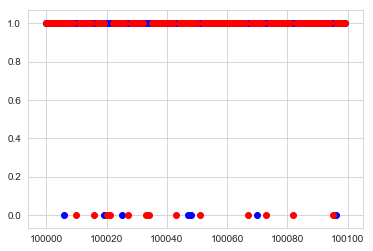

In [65]:
predictions = rf.predict(X_test)
y_test_encoded = lab_enc.fit_transform(y_test)
rf_score= accuracy_score(pd.DataFrame(rf.predict(X_test)),y_test_encoded)
y=predictions[:100]
show_test = aptdata.Show[100000:]
show_test=show_test[:100]
show_test=show_test.reset_index()
plt.scatter(show_test['index'], show_test['Show'], c='b', label = 'data') #blue is true value
plt.scatter(show_test['index'], y, c='r', label = 'prediction') #red is predicted value
rf_score

The random forest does a great job in classifying the participants that showed up to their appointments but they falsely classify the participants that do not show up to their appointments.

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_encoded, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_encoded, predictions))
print('\n')

=== Confusion Matrix ===
[[ 1846  4788]
 [ 3292 23233]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.36      0.28      0.31      6634
           1       0.83      0.88      0.85     26525

   micro avg       0.76      0.76      0.76     33159
   macro avg       0.59      0.58      0.58     33159
weighted avg       0.74      0.76      0.74     33159





In [67]:
list(zip(aptdata.drop(['PatientId','AppointmentID','Gender','ScheduledDay','AppointmentDay','No-show', 'Show'],1), rf.feature_importances_))

[('Age', 0.31298758599638965),
 ('Neighborhood', 0.29597472783617),
 ('Scholarship', 0.008597076018738022),
 ('Hypertension', 0.007269255531561912),
 ('Diabetes', 0.0060088892472648535),
 ('Alcoholism', 0.005413181282067082),
 ('Handicap', 0.006413155637554016),
 ('SMS_received', 0.012704287987342014),
 ('daystillapt', 0.2568257866268825),
 ('WeekdayNum', 0.06486958815650061),
 ('Sex', 0.02293646567952947)]

# Random Forest Classification Model
A Random Forest Classification model was used on this dataset to get an accuracy score of 75.6%. When doing further exploration on the results of the model, the precision, recall, and f1 scores showed that the model did a good job in classifying the participants that showed up, but did not do as well when classifying the participants that did not show up.  The random forest model also showed which features had the most predictive power.  These features in order of predictive power were Age, Neighborhood, and daystillapt. 

In [68]:
gb= GradientBoostingClassifier(learning_rate=0.1, n_estimators=120
                            ,max_depth=10, min_samples_split= 8,
                               max_features='sqrt', 
                                    subsample=0.8, random_state=42)
gb.fit(X_train,y_train_encoded)
gb_pre=gb.predict(X_train)
accuracy_score(pd.DataFrame(gb.predict(X_train)),y_train_encoded)

0.8478699203805191

In [69]:
gb.predict(X_test)
gb_score=accuracy_score(pd.DataFrame(gb.predict(X_test)),y_test_encoded)
gb_score

0.7996622334811062

0.7996622334811062

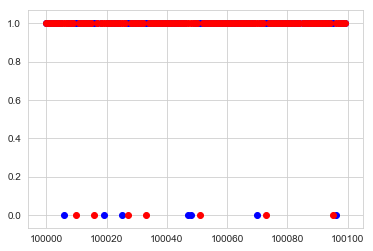

In [70]:
predictions = gb.predict(X_test)
gb_score= accuracy_score(pd.DataFrame(gb.predict(X_test)),y_test_encoded)
y=predictions[:100]
show_test = aptdata.Show[100000:]
show_test=show_test[:100]
show_test=show_test.reset_index()
plt.scatter(show_test['index'], show_test['Show'], c='b', label = 'data') #blue is true value
plt.scatter(show_test['index'], y, c='r', label = 'prediction') #red is predicted value
gb_score

In [71]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test_encoded, predictions))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test_encoded, predictions))
print('\n')

=== Confusion Matrix ===
[[  666  5968]
 [  675 25850]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.10      0.17      6634
           1       0.81      0.97      0.89     26525

   micro avg       0.80      0.80      0.80     33159
   macro avg       0.65      0.54      0.53     33159
weighted avg       0.75      0.80      0.74     33159





In [72]:
list(zip(aptdata.drop(['PatientId','AppointmentID','Gender','ScheduledDay','AppointmentDay','No-show', 'Show'],1), rf.feature_importances_))

[('Age', 0.31298758599638965),
 ('Neighborhood', 0.29597472783617),
 ('Scholarship', 0.008597076018738022),
 ('Hypertension', 0.007269255531561912),
 ('Diabetes', 0.0060088892472648535),
 ('Alcoholism', 0.005413181282067082),
 ('Handicap', 0.006413155637554016),
 ('SMS_received', 0.012704287987342014),
 ('daystillapt', 0.2568257866268825),
 ('WeekdayNum', 0.06486958815650061),
 ('Sex', 0.02293646567952947)]

# Gradient Boosting Classification Model
A Gradient Boosting Classification model was used on this dataset to get an accuracy score of 80%. Similar to the random forest model, the precision, recall, and f1 scores showed that the model did a good job in classifying the participants that showed up, but did not do as well when classifying the participants that did not show up. The recall and f1 score performed worse for the gradient boosting classifier than the random forest classifier. The important features had the most predictive power for this model were the same as the random forest classification model: Age, Neighborhood, and daystillapt.

In [24]:
algorithms = [rf_score,gb_score]
names= ['Random Forest','Gradient Boosting']
final = pd.DataFrame([names,algorithms]).T
final.columns =['Algorithms', 'Accuracy Score'] 

In [25]:
final

,Algorithms,Accuracy Score
0,Random Forest,0.756537
1,Gradient Boosting,0.799662
